# 05a2 – Enhanced 3-Step Floating Catchment Area (E3SFCA) Scenario Modelling

## Overview

This notebook implements the **Enhanced 3-Step Floating Catchment Area (E3SFCA)** model to estimate spatial accessibility to CT scanner services across LSOAs in England. The E3SFCA method builds on the traditional 2SFCA by incorporating:

- Decay functions based on **realistic travel time bands** (car mode),
- **Weighted supply-to-demand ratios** per CT site (Rⱼ),
- **Aggregated accessibility scores (Fᵢ)** for each LSOA, reflecting cumulative opportunity adjusted for catchment overlap and travel friction.

This model serves as the **baseline scenario** for accessibility modelling prior to adding new sites or testing alternative service distributions.

---

## Key Objectives

- Apply a **stepwise decay function** to account for declining willingness to travel with increasing time.
- Compute supply-to-demand ratios (**Rⱼ**) at each CT facility using weighted demand from surrounding LSOAs.
- Generate accessibility scores (**Fᵢ**) per LSOA as the sum of all weighted contributions from accessible facilities.
- Export all outputs for downstream comparison and mapping (e.g., accessibility delta plots, prioritisation maps).

---

## Input Datasets

- LSOA-level demand estimates and geometry (`gdf_lsoa`)
- CT scanner site locations and capacity (`df_sites_ct`)
- Travel time matrix between all LSOAs and CT sites by car (`df_travel_car`)

---

## Outputs

The following datasets are exported to `/data/processed/E3SFCA/`:

- LSOA accessibility scores (GeoPackage + CSV)
- Travel matrix with decay weights
- CT site supply-to-demand ratio table (Rⱼ values)
- CT site capability table with scanner counts

---

## Planning Utility

The E3SFCA score (Fᵢ) can be used to:

- Identify LSOAs with **low spatial access** to CT scanning services,
- Support **site placement strategies** by revealing coverage deserts,
- Quantify the impact of **proposed infrastructure** on accessibility equity.

This model underpins scenario testing in subsequent notebooks (`05a3`, `06a`, etc.).


In [16]:
# ----------------------------------------------------------
# Step 0 – Imports and Display Setup
# ----------------------------------------------------------

import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import contextily as ctx
import os

# Optional
import warnings
warnings.filterwarnings("ignore")


In [17]:
# ----------------------------------------------------------
# Step 1 – Load Baseline E3SFCA Files (Car Mode + Site Types)
# ----------------------------------------------------------

# Base directory structure
base_dir = "/Users/rosstaylor/Downloads/Research Project/Code Folder/diagnostic-modality-demand/diagnostic-modality-demand"
data_dir = os.path.join(base_dir, "data")
processed_dir = os.path.join(data_dir, "processed")
raw_dir = os.path.join(data_dir, "raw")

# E3SFCA input files
lsoa_access_path = os.path.join(processed_dir, "E3SFCA", "lsoa_e3sfca_accessibility_2024.gpkg")
travel_matrix_path = os.path.join(processed_dir, "E3SFCA", "lsoa_to_ct_travel_matrix_car.csv")
ct_sites_path = os.path.join(processed_dir, "E3SFCA", "ct_sites_capability.csv")
rj_path = os.path.join(processed_dir, "E3SFCA", "ct_site_rj_scores_car.csv")

# Load baseline outputs
gdf_lsoa = gpd.read_file(lsoa_access_path)
df_travel_car = pd.read_csv(travel_matrix_path)
df_sites_ct = pd.read_csv(ct_sites_path)
df_rj_car = pd.read_csv(rj_path)

# Raw site capability input (for acute and CDC identification)
acute_path = os.path.join(raw_dir, "modality_modelling", "NHS_SW_Acute_Hospitals_Capability.csv")
cdc_path = os.path.join(raw_dir, "modality_modelling", "NHS_SW_Community_Diagnostic_Centres_Capability.csv")

df_sites_acute = pd.read_csv(acute_path)
df_sites_cdc = pd.read_csv(cdc_path)

travel_matrix_path = "/Users/rosstaylor/Downloads/Research Project/Code Folder/diagnostic-modality-demand/diagnostic-modality-demand/data/raw/LSOA_to_LSOA_complete.csv"


# Confirm shapes
print(f"LSOA GeoDataFrame: {gdf_lsoa.shape}")
print(f"Travel Matrix (car ≤60 min): {df_travel_car.shape}")
print(f"CT Sites: {df_sites_ct.shape}")
print(f"Acute Sites: {df_sites_acute.shape}")
print(f"CDC Sites: {df_sites_cdc.shape}")


LSOA GeoDataFrame: (3451, 10)
Travel Matrix (car ≤60 min): (2115893, 16)
CT Sites: (36, 23)
Acute Sites: (18, 23)
CDC Sites: (24, 22)


In [18]:
# ----------------------------------------------------------
# Step 1a – Filter Acute and CDC Sites with >0 CT Scanners
# ----------------------------------------------------------

# Clean CT scanner columns (ensure numeric and fill NaNs as 0)
df_sites_acute["CT Scanners"] = pd.to_numeric(df_sites_acute["CT Scanners"], errors="coerce").fillna(0)
df_sites_cdc["CT Scanners"] = pd.to_numeric(df_sites_cdc["CT Scanners"], errors="coerce").fillna(0)

# Filter for sites with 1 or more scanners
df_acute_ct = df_sites_acute[df_sites_acute["CT Scanners"] > 0].copy()
df_cdc_ct = df_sites_cdc[df_sites_cdc["CT Scanners"] > 0].copy()

# Summary counts
print(f"Acute sites with ≥1 CT scanner: {df_acute_ct.shape[0]}")
print(f"CDC sites with ≥1 CT scanner: {df_cdc_ct.shape[0]}")


Acute sites with ≥1 CT scanner: 18
CDC sites with ≥1 CT scanner: 18


In [43]:
# ----------------------------------------------------------
# Step 1a – Filter Acute and CDC Sites with >0 CT Scanners
# ----------------------------------------------------------

# Clean CT scanner columns (ensure numeric and fill NaNs as 0)
df_sites_acute["CT Scanners"] = (
    pd.to_numeric(df_sites_acute["CT Scanners"], errors="coerce")
      .fillna(0)
      .astype(int)
)
df_sites_cdc["CT Scanners"] = (
    pd.to_numeric(df_sites_cdc["CT Scanners"], errors="coerce")
      .fillna(0)
      .astype(int)
)

# Filter for sites with ≥1 scanner
df_acute_ct = df_sites_acute[df_sites_acute["CT Scanners"] > 0].copy()
df_cdc_ct   = df_sites_cdc[df_sites_cdc["CT Scanners"] > 0].copy()

# Add a site_type column
df_acute_ct["site_type"] = "Acute"
df_cdc_ct  ["site_type"] = "CDC"

# Convert to GeoDataFrames for spatial consistency
acute_gdf = gpd.GeoDataFrame(
    df_acute_ct,
    geometry=gpd.points_from_xy(df_acute_ct["latitude"], df_acute_ct["longitude"]),
    crs="EPSG:4326"
)
cdc_gdf = gpd.GeoDataFrame(
    df_cdc_ct,
    
    # Corrected Geometry Assignment
    geometry=gpd.points_from_xy(df_acute_ct["latitude"], df_acute_ct["longitude"]),

    crs="EPSG:4326"
)

# Summary counts
print(f"Acute sites with ≥1 CT scanner: {acute_gdf.shape[0]}")
print(f"CDC   sites with ≥1 CT scanner: {cdc_gdf.shape[0]}")

# Quick head check
print("\nAcute CT sites sample:")
print(acute_gdf[["site_type", "Code", "Name", "CT Scanners", "geometry"]].head())

print("\nCDC CT sites sample:")
print(cdc_gdf[["site_type", "Code", "Name", "CT Scanners", "geometry"]].head())


Acute sites with ≥1 CT scanner: 18
CDC   sites with ≥1 CT scanner: 18

Acute CT sites sample:
  site_type   Code                            Name  CT Scanners  \
0     Acute  RTE01     Cheltenham General Hospital            2   
1     Acute  RTE03  Gloucestershire Royal Hospital            4   
2     Acute  RH5A8          Musgrove Park Hospital            3   
3     Acute  RH5O4        Yeovil District Hospital            2   
4     Acute  RA701         Bristol Royal Infirmary            5   

                    geometry  
0  POINT (-2.07188 51.89212)  
1  POINT (-2.23207 51.86638)  
2  POINT (-3.12169 51.01157)  
3  POINT (-2.63471 50.94484)  
4  POINT (-2.59614 51.45918)  

CDC CT sites sample:
  site_type   Code                    Name  CT Scanners  \
0       CDC  B4B4S  Bsw Banes Locality CDC            1   
1       CDC  K1W4U           Salisbury CDC            1   
2       CDC  O0D8X        West Swindon CDC            1   
3       CDC  O1F4J              Weston CDC            1   


In [45]:
# ----------------------------------------------------------
# Step 1b – Build the Baseline Supply GeoDataFrame
# ----------------------------------------------------------

# 1. Concatenate Acute and CDC GeoDataFrames
baseline_gdf = pd.concat([acute_gdf, cdc_gdf], ignore_index=True)

# 2. Standardise column names
baseline_gdf = baseline_gdf.rename(columns={
    "Name": "site_name",
    "CT Scanners": "scanner_count",
    "lsoa21cd": "destination_name"
})

# 3. Add site_type if missing (should already be set)
baseline_gdf["site_type"] = baseline_gdf["site_type"].fillna("Baseline")

# 4. Ensure CRS is WGS84
baseline_gdf = gpd.GeoDataFrame(baseline_gdf, geometry="geometry", crs="EPSG:4326")

# 5. Extract correct latitude and longitude from geometry (order: y = lat, x = lon)
baseline_gdf["latitude"] = baseline_gdf.geometry.y
baseline_gdf["longitude"] = baseline_gdf.geometry.x

# 6. Select & reorder columns to match scenario structure
baseline_gdf = baseline_gdf[
    ["site_name", "scanner_count", "site_type", 
     "latitude", "longitude", "geometry", "destination_name"]
].copy()

# 7. Quick head check
print("── Baseline Supply GeoDataFrame ──")
print(baseline_gdf.columns.tolist())
print(baseline_gdf.head())


── Baseline Supply GeoDataFrame ──
['site_name', 'scanner_count', 'site_type', 'latitude', 'longitude', 'geometry', 'destination_name']
                        site_name  scanner_count site_type   latitude  \
0     Cheltenham General Hospital              2     Acute  51.892120   
1  Gloucestershire Royal Hospital              4     Acute  51.866379   
2          Musgrove Park Hospital              3     Acute  51.011574   
3        Yeovil District Hospital              2     Acute  50.944843   
4         Bristol Royal Infirmary              5     Acute  51.459183   

   longitude                   geometry destination_name  
0  -2.071883  POINT (-2.07188 51.89212)        E01022116  
1  -2.232073  POINT (-2.23207 51.86638)        E01022312  
2  -3.121693  POINT (-3.12169 51.01157)        E01029302  
3  -2.634712  POINT (-2.63471 50.94484)        E01029231  
4  -2.596139  POINT (-2.59614 51.45918)        E01033904  


In [21]:
# ----------------------------------------------------------
# Step 2 – Identify Priority Underserved LSOAs (High Demand + Low Access)
# ----------------------------------------------------------

# 1. Define thresholds for "low access" (bottom 33%) and "high demand" (above median)
score_threshold = gdf_lsoa["enhanced_3sfca_score"].quantile(0.33)   # bottom 33%
demand_threshold = gdf_lsoa["ct_total_demand"].median()             # above-median demand

# 2. Apply filters
gdf_lsoa["low_access"] = gdf_lsoa["enhanced_3sfca_score"] <= score_threshold
gdf_lsoa["high_demand"] = gdf_lsoa["ct_total_demand"] >= demand_threshold

# 3. Tag LSOAs that meet both criteria
gdf_lsoa["priority_underserved"] = gdf_lsoa["low_access"] & gdf_lsoa["high_demand"]

# 4. Create filtered GeoDataFrame
gdf_priority = gdf_lsoa[gdf_lsoa["priority_underserved"]].copy()

# 5. Output check
print(f"Priority underserved LSOAs identified: {gdf_priority.shape[0]} of {gdf_lsoa.shape[0]}")


Priority underserved LSOAs identified: 713 of 3451


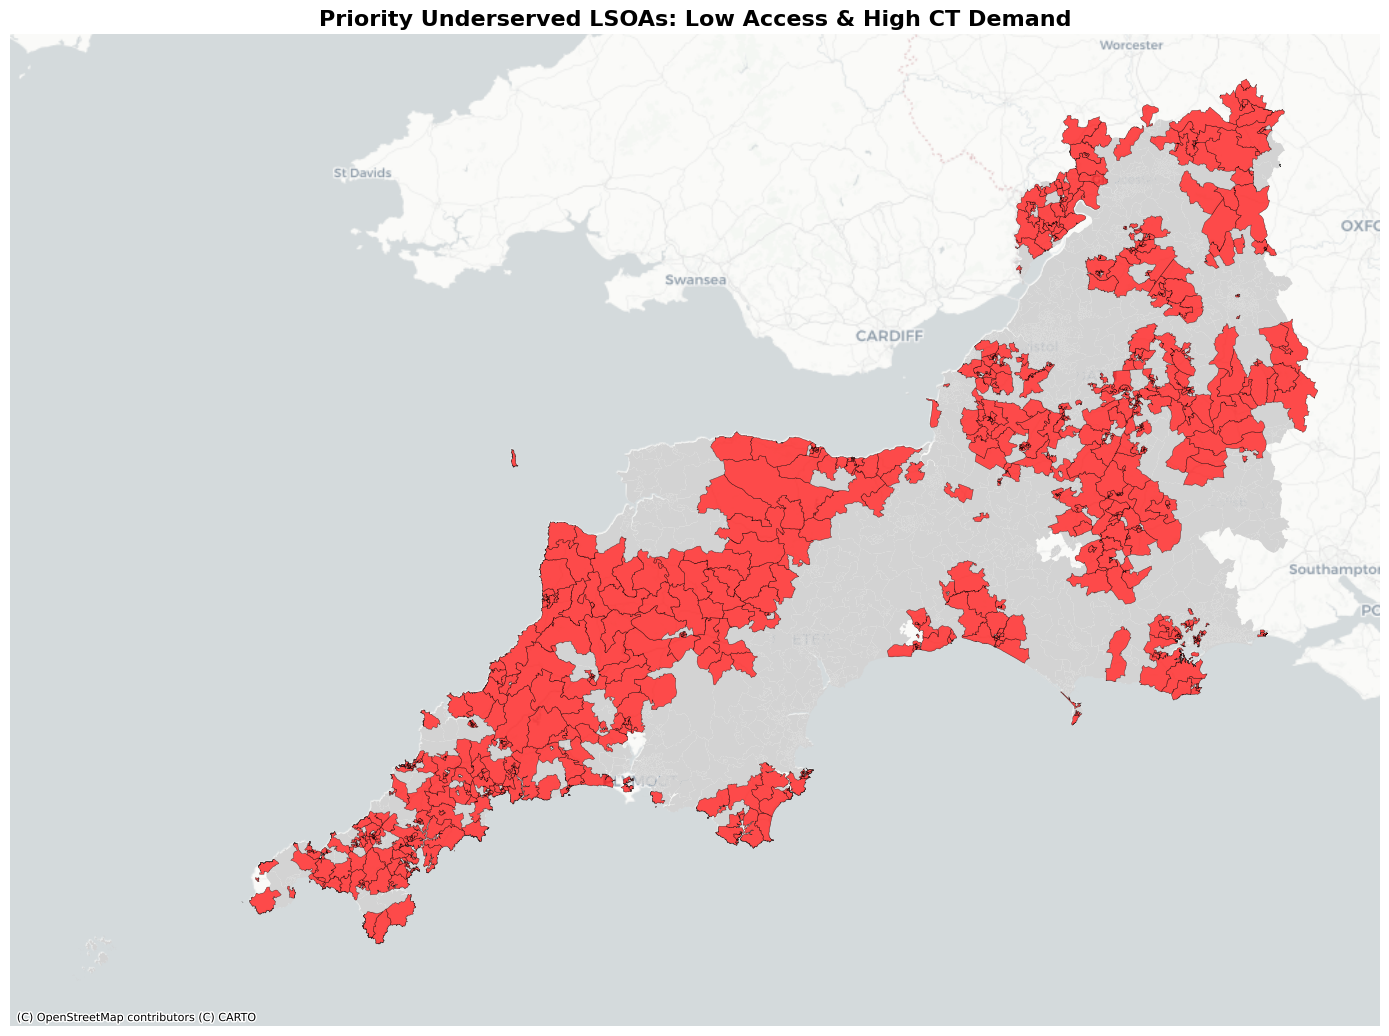

In [22]:
# ----------------------------------------------------------
# Step 2a – Visualise Priority Underserved LSOAs (Preferred Style)
# ----------------------------------------------------------

# Reproject to Web Mercator for tile basemaps
gdf_lsoa_plot = gdf_lsoa.to_crs(epsg=3857)

# Split into priority and non-priority groups
gdf_priority_plot = gdf_lsoa_plot[gdf_lsoa_plot["priority_underserved"] == True]
gdf_nonpriority_plot = gdf_lsoa_plot[gdf_lsoa_plot["priority_underserved"] == False]

# Plot setup
fig, ax = plt.subplots(figsize=(14, 11))

# Plot non-priority in light grey
gdf_nonpriority_plot.plot(
    ax=ax,
    color="lightgrey",
    edgecolor="none"
)

# Plot priority LSOAs in semi-transparent red with black borders
gdf_priority_plot.plot(
    ax=ax,
    color="red",
    alpha=0.7,
    edgecolor="black",
    linewidth=0.3
)

# Add basemap
ctx.add_basemap(
    ax,
    crs=gdf_lsoa_plot.crs,
    source=ctx.providers.CartoDB.Positron
)

# Formatting
ax.set_title("Priority Underserved LSOAs: Low Access & High CT Demand", fontsize=16, weight='bold')
ax.axis("off")
plt.tight_layout()
plt.show()


In [23]:
# ----------------------------------------------------------
# Step 2b – Propose Total CT Scanner Uplift Scenarios (5%, 10%, 20%)
# ----------------------------------------------------------

# Calculate current total scanners
current_total_scanners = df_sites_ct["CT Scanners"].sum()
print(f"Current total CT scanners: {current_total_scanners}")

# Define percentage increases
uplift_factors = [0.05, 0.10, 0.20]

# Create scenario summary table
uplift_summary = []

for factor in uplift_factors:
    new_total = round(current_total_scanners * (1 + factor))
    uplift = new_total - current_total_scanners
    uplift_summary.append({
        "Scenario": f"+{int(factor * 100)}%",
        "New Total CT Scanners": new_total,
        "Uplift": uplift
    })

# Convert to DataFrame for display
df_uplift = pd.DataFrame(uplift_summary)
print(df_uplift)


Current total CT scanners: 78
  Scenario  New Total CT Scanners  Uplift
0      +5%                     82       4
1     +10%                     86       8
2     +20%                     94      16


In [25]:
# ----------------------------------------------------------
# Step 3 – Cluster and Rank Underserved LSOAs to Propose New Sites
# ----------------------------------------------------------

from sklearn.cluster import KMeans
import geopandas as gpd

def generate_clustered_scenario_sites(gdf_priority, scenario_configs,
                                      score_col="enhanced_3sfca_score",  # <- Updated
                                      demand_col="ct_total_demand"):
    """
    Applies KMeans clustering to identify proposed CT sites under multiple scenarios.

    Parameters:
    - gdf_priority: GeoDataFrame of underserved LSOAs
                    (must include centroid x/y, score, and demand columns)
    - scenario_configs: Dict of form {
          "scenario_name": {
              "n_clusters": int,
              "scanner_allocation": List[int]
          }
      }
    - score_col: Column name of accessibility score (default: 'enhanced_3sfca_score')
    - demand_col: Column name of demand (default: 'ct_total_demand')

    Returns:
    - Dict of {scenario_name: GeoDataFrame of proposed scenario site locations}
    """
    scenario_outputs = {}

    for scenario, config in scenario_configs.items():
        n_clusters = config["n_clusters"]
        scanner_allocation = config["scanner_allocation"]

        if len(scanner_allocation) != n_clusters:
            raise ValueError(
                f"Scenario '{scenario}': scanner_allocation ({len(scanner_allocation)}) "
                f"does not match n_clusters ({n_clusters})"
            )

        # Copy base GeoDataFrame
        gdf_scenario = gdf_priority.copy()

        # Ensure 'x' and 'y' exist
        if "x" not in gdf_scenario.columns or "y" not in gdf_scenario.columns:
            gdf_scenario["centroid"] = gdf_scenario.geometry.centroid
            gdf_scenario["x"] = gdf_scenario["centroid"].x
            gdf_scenario["y"] = gdf_scenario["centroid"].y

        # Apply KMeans
        coords = gdf_scenario[["x", "y"]].values
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        gdf_scenario["cluster"] = kmeans.fit_predict(coords)

        # Summarise stats per cluster
        cluster_stats = (
            gdf_scenario
            .groupby("cluster")
            .agg(
                total_demand=(demand_col, "sum"),
                avg_access_score=(score_col, "mean"),
                lsoa_count=("lsoa21cd", "count"),
                x_mean=("x", "mean"),
                y_mean=("y", "mean")
            )
            .reset_index()
        )

        # Composite ranking: high demand, low access
        cluster_stats["rank_score"] = (
            cluster_stats["total_demand"].rank(ascending=False) +
            cluster_stats["avg_access_score"].rank(ascending=True)
        )
        cluster_stats["rank"] = cluster_stats["rank_score"].rank(method="dense").astype(int)

        # Assign scanners and name sites
        cluster_stats = cluster_stats.sort_values("rank").reset_index(drop=True)
        cluster_stats["CT Scanners"] = scanner_allocation[:len(cluster_stats)]
        cluster_stats["Site Name"] = cluster_stats.index.map(lambda i: f"Scenario Site {i+1}")
        cluster_stats["Type"] = f"Scenario {scenario}"

        # Convert to GeoDataFrame
        gdf_sites = gpd.GeoDataFrame(
            cluster_stats,
            geometry=gpd.points_from_xy(cluster_stats["x_mean"], cluster_stats["y_mean"]),
            crs="EPSG:3857"

        )

        scenario_outputs[scenario] = gdf_sites

    return scenario_outputs


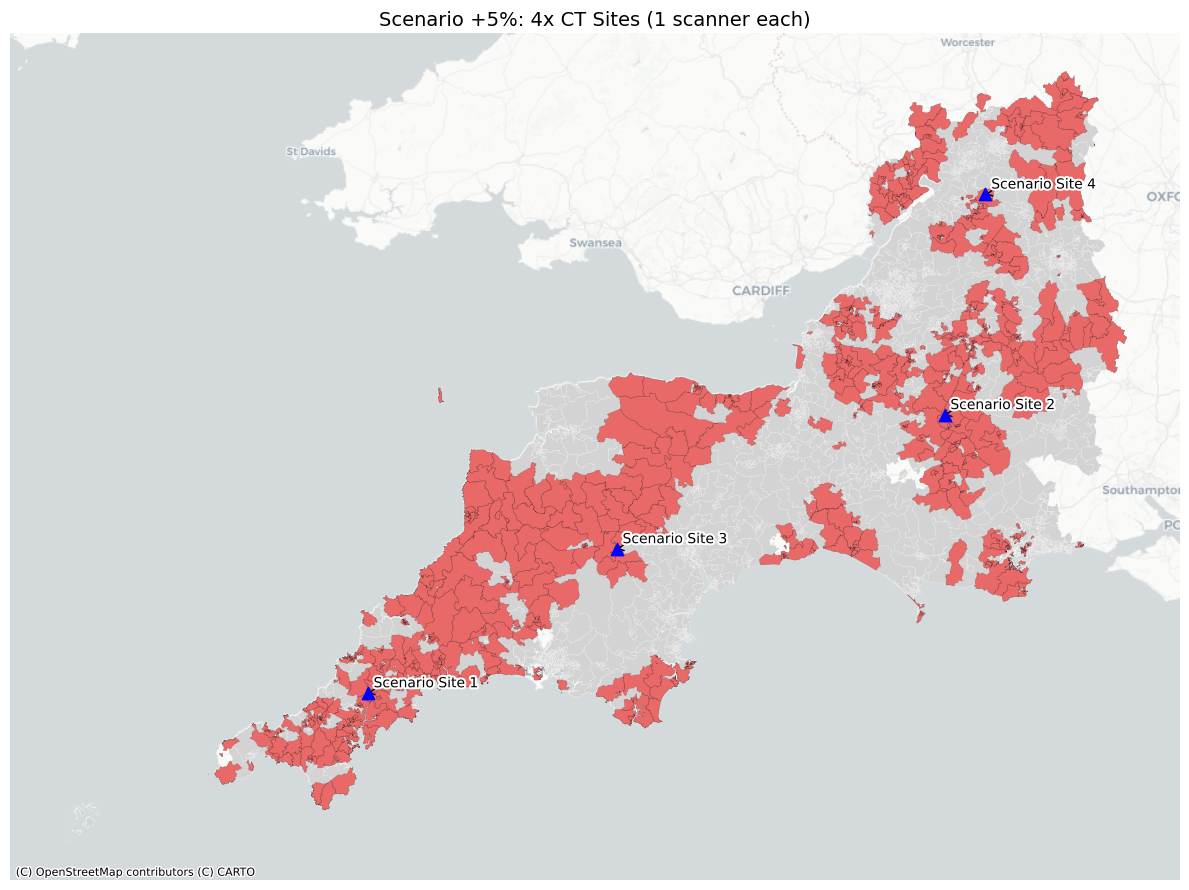

In [26]:
# ----------------------------------------------------------
# Step 3a – +5% Scenario: 4x CT Sites (1 scanner each)
# ----------------------------------------------------------

import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects

# Reproject priority LSOAs to EPSG:3857 before clustering
gdf_priority_proj = gdf_priority.to_crs(epsg=3857).copy()

# Ensure centroid, x, y columns exist in projected space
if "x" not in gdf_priority_proj.columns or "y" not in gdf_priority_proj.columns:
    gdf_priority_proj["centroid"] = gdf_priority_proj.geometry.centroid
    gdf_priority_proj["x"] = gdf_priority_proj["centroid"].x
    gdf_priority_proj["y"] = gdf_priority_proj["centroid"].y

# Define scenario configuration
config_5 = {"+5%": {"n_clusters": 4, "scanner_allocation": [1, 1, 1, 1]}}

# Generate proposed site locations using projected centroids
sites_5pct = generate_clustered_scenario_sites(gdf_priority_proj, config_5)["+5%"]

# Reproject base and priority LSOAs to EPSG:3857 for plotting
gdf_base = gdf_lsoa.to_crs(epsg=3857)
gdf_priority_plot = gdf_priority_proj  # already projected

# Plot
fig, ax = plt.subplots(figsize=(12, 10))
gdf_base.plot(ax=ax, color="lightgrey", edgecolor="white", linewidth=0.1)
gdf_priority_plot.plot(ax=ax, color="red", alpha=0.5, edgecolor="black", linewidth=0.2)

# Plot scenario sites (1 scanner each only)
for _, row in sites_5pct.iterrows():
    ax.scatter(row.geometry.x, row.geometry.y, marker="^", s=80, color="blue", zorder=5)
    ax.annotate(
        row["Site Name"],
        xy=(row.geometry.x, row.geometry.y),
        xytext=(row.geometry.x + 3000, row.geometry.y + 3000),
        arrowprops=dict(arrowstyle="->", color="black", lw=1),
        fontsize=10,
        path_effects=[path_effects.withStroke(linewidth=3, foreground="white")]
    )

# Basemap and title
ctx.add_basemap(ax, crs=sites_5pct.crs, source=ctx.providers.CartoDB.Positron)
ax.set_title("Scenario +5%: 4x CT Sites (1 scanner each)", fontsize=14)
ax.axis("off")
plt.tight_layout()
plt.show()


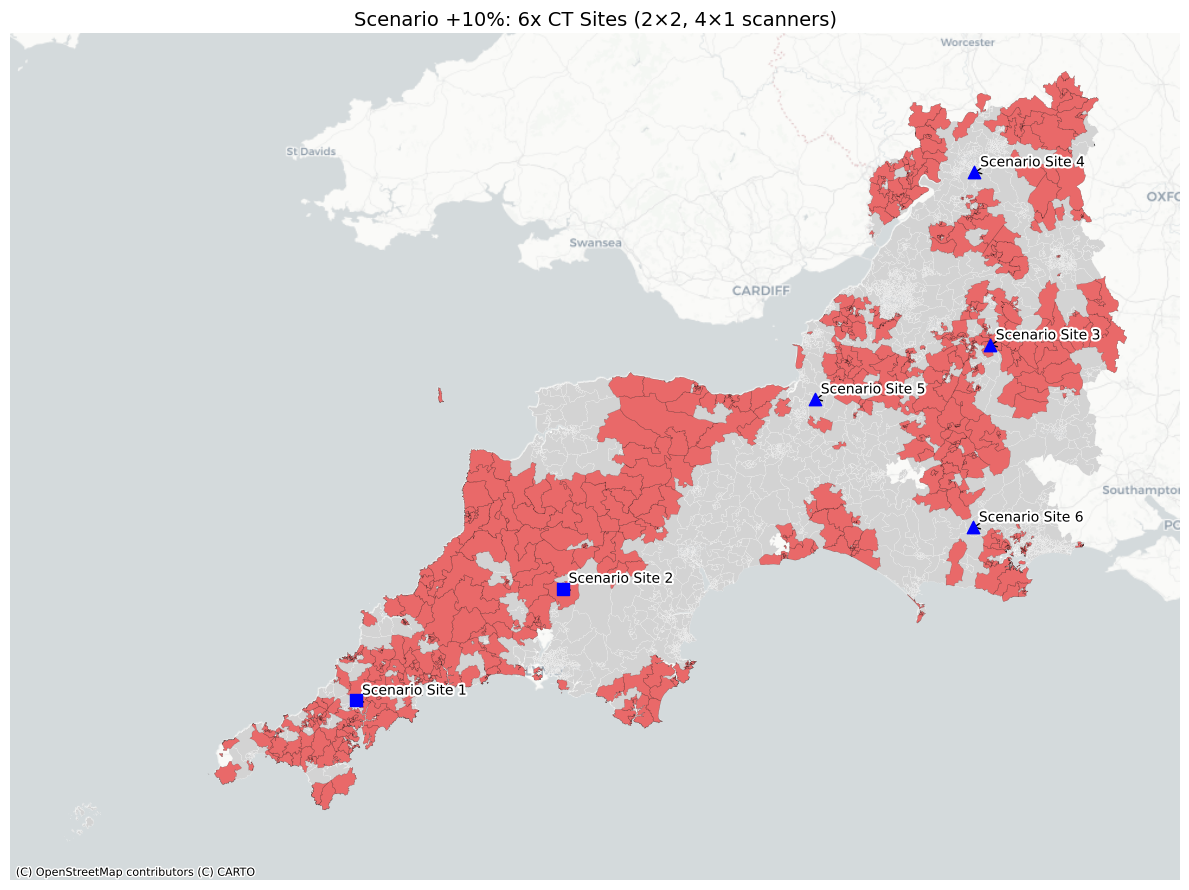

In [30]:
# ----------------------------------------------------------
# Step 3b – +10% Scenario: 6x CT Sites (2×2, 4×1 scanners)
# ----------------------------------------------------------

import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects

# Reproject priority LSOAs to EPSG:3857 before clustering
gdf_priority_proj = gdf_priority.to_crs(epsg=3857).copy()

# Ensure centroid, x, y columns exist
if "x" not in gdf_priority_proj.columns or "y" not in gdf_priority_proj.columns:
    gdf_priority_proj["centroid"] = gdf_priority_proj.geometry.centroid
    gdf_priority_proj["x"] = gdf_priority_proj["centroid"].x
    gdf_priority_proj["y"] = gdf_priority_proj["centroid"].y

# Define scenario configuration
config_10 = {"+10%": {"n_clusters": 6, "scanner_allocation": [2, 2, 1, 1, 1, 1]}}

# Generate proposed site locations using projected centroids
sites_10pct = generate_clustered_scenario_sites(gdf_priority_proj, config_10)["+10%"]

# Reproject base and priority LSOAs to EPSG:3857 for plotting
gdf_base = gdf_lsoa.to_crs(epsg=3857)
gdf_priority_plot = gdf_priority_proj  # already projected

# Plot
fig, ax = plt.subplots(figsize=(12, 10))
gdf_base.plot(ax=ax, color="lightgrey", edgecolor="white", linewidth=0.1)
gdf_priority_plot.plot(ax=ax, color="red", alpha=0.5, edgecolor="black", linewidth=0.2)

# Plot sites with different markers for 1 vs 2 scanners
for _, row in sites_10pct.iterrows():
    marker = "^" if row["CT Scanners"] == 1 else "s"
    ax.scatter(row.geometry.x, row.geometry.y, marker=marker, s=80, color="blue", zorder=5)
    ax.annotate(
        row["Site Name"],
        xy=(row.geometry.x, row.geometry.y),
        xytext=(row.geometry.x + 3000, row.geometry.y + 3000),
        arrowprops=dict(arrowstyle="->", color="black", lw=1),
        fontsize=10,
        path_effects=[path_effects.withStroke(linewidth=3, foreground="white")]
    )

# Basemap and title
ctx.add_basemap(ax, crs=sites_10pct.crs, source=ctx.providers.CartoDB.Positron)
ax.set_title("Scenario +10%: 6x CT Sites (2×2, 4×1 scanners)", fontsize=14)
ax.axis("off")
plt.tight_layout()
plt.show()


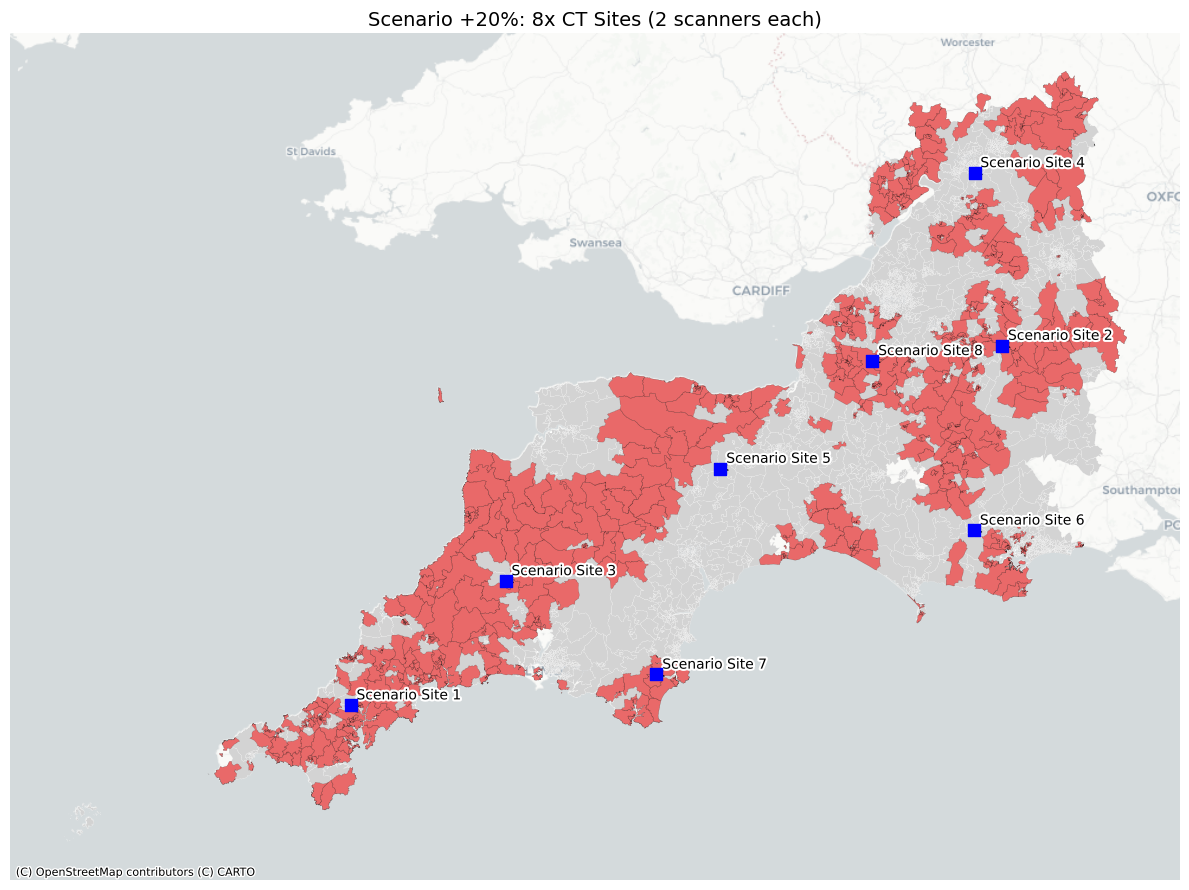

In [31]:
# ----------------------------------------------------------
# Step 3c – +20% Scenario: 8x CT Sites (2 scanners each)
# ----------------------------------------------------------

import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects

# Reproject priority LSOAs to EPSG:3857 before clustering
gdf_priority_proj = gdf_priority.to_crs(epsg=3857).copy()

# Ensure centroid, x, y columns exist
if "x" not in gdf_priority_proj.columns or "y" not in gdf_priority_proj.columns:
    gdf_priority_proj["centroid"] = gdf_priority_proj.geometry.centroid
    gdf_priority_proj["x"] = gdf_priority_proj["centroid"].x
    gdf_priority_proj["y"] = gdf_priority_proj["centroid"].y

# Define scenario configuration
config_20 = {"+20%": {"n_clusters": 8, "scanner_allocation": [2] * 8}}

# Generate proposed site locations
sites_20pct = generate_clustered_scenario_sites(gdf_priority_proj, config_20)["+20%"]

# Reproject base and priority LSOAs to EPSG:3857 for plotting
gdf_base = gdf_lsoa.to_crs(epsg=3857)
gdf_priority_plot = gdf_priority_proj  # already projected

# Plot
fig, ax = plt.subplots(figsize=(12, 10))
gdf_base.plot(ax=ax, color="lightgrey", edgecolor="white", linewidth=0.1)
gdf_priority_plot.plot(ax=ax, color="red", alpha=0.5, edgecolor="black", linewidth=0.2)

# Plot all scenario sites (2 scanners each) as squares
for _, row in sites_20pct.iterrows():
    ax.scatter(row.geometry.x, row.geometry.y, marker="s", s=80, color="blue", zorder=5)
    ax.annotate(
        row["Site Name"],
        xy=(row.geometry.x, row.geometry.y),
        xytext=(row.geometry.x + 3000, row.geometry.y + 3000),
        arrowprops=dict(arrowstyle="->", color="black", lw=1),
        fontsize=10,
        path_effects=[path_effects.withStroke(linewidth=3, foreground="white")]
    )

# Add basemap and final plot formatting
ctx.add_basemap(ax, crs=sites_20pct.crs, source=ctx.providers.CartoDB.Positron)
ax.set_title("Scenario +20%: 8x CT Sites (2 scanners each)", fontsize=14)
ax.axis("off")
plt.tight_layout()
plt.show()


In [32]:
# ----------------------------------------------------------
# Step 4 – Print Ranked Summary of Proposed Sites per Scenario
# ----------------------------------------------------------

columns_to_show = ["Site Name", "total_demand", "avg_access_score", "rank"]

# +5% Scenario
print("\n+5% Scenario: 4x CT Sites (1 scanner each)")
print(sites_5pct[columns_to_show].sort_values("rank").to_string(index=False))

# +10% Scenario
print("\n+10% Scenario: 6x CT Sites (2×2, 4×1 scanners)")
print(sites_10pct[columns_to_show].sort_values("rank").to_string(index=False))

# +20% Scenario
print("\n+20% Scenario: 8x CT Sites (2 scanners each)")
print(sites_20pct[columns_to_show].sort_values("rank").to_string(index=False))



+5% Scenario: 4x CT Sites (1 scanner each)
      Site Name  total_demand  avg_access_score  rank
Scenario Site 1  40351.897797          0.030757     1
Scenario Site 2  67896.413155          0.051704     2
Scenario Site 3  33007.721739          0.037511     2
Scenario Site 4  32844.513992          0.048879     3

+10% Scenario: 6x CT Sites (2×2, 4×1 scanners)
      Site Name  total_demand  avg_access_score  rank
Scenario Site 1  35972.891493          0.029831     1
Scenario Site 2  28912.210980          0.038552     2
Scenario Site 3  33409.621464          0.046735     2
Scenario Site 4  26680.864007          0.047099     3
Scenario Site 5  26368.588763          0.051021     4
Scenario Site 6  22756.369976          0.055944     5

+20% Scenario: 8x CT Sites (2 scanners each)
      Site Name  total_demand  avg_access_score  rank
Scenario Site 1  33361.453991          0.029268     1
Scenario Site 2  28921.223092          0.045093     2
Scenario Site 3  21369.859338          0.035215     

### How Are New CT Scanner Sites Located?

This scenario modelling approach uses a data-driven method to place new scanner sites based on population need and geographic equity. Here's how it works:

---

#### 1. Identify Underserved Areas  
The model begins by identifying neighbourhoods (LSOAs) that:
- Have **high demand** for CT scanning (based on total need), and  
- Have **low spatial access** to existing scanners (using the 3SFCA score).

These areas are prioritised for intervention.

---

#### 2. Cluster Underserved Areas by Location  
The selected priority LSOAs are grouped using **K-Means clustering**, which groups them based on their physical location (longitude and latitude).  
Each group represents a distinct catchment area where a new CT site could serve unmet need.

---

#### 3. Place New Sites at Cluster Centres  
For each cluster, the model places a new CT site at the **centroid** of that group—the average location of all LSOAs within it.  
This ensures that new facilities are well-positioned relative to the population they are intended to serve.

---

#### 4. Allocate Scanners Across Proposed Sites  
Scanners are distributed across the proposed sites according to the uplift scenario:
- For example, under a +10% scenario (8 new scanners), the model might allocate:
  - 2 scanners to the largest 2 clusters, and
  - 1 scanner to each of 4 smaller clusters.

This allocation is based on a composite ranking of each cluster’s demand and current access level.

---

#### 5. Link Sites to Real LSOAs  
Each proposed site is matched to the **nearest real LSOA**, so that it can be assigned to known geographic units, enabling:
- Population linkage,
- Travel time calculation,
- Visualisation in maps.

---

#### Summary  
> The model finds the most underserved areas, groups them geographically, and places new scanner sites at the centre of each group—assigning scanners in proportion to need. Each proposed site is linked to a real postcode area for visualisation and further analysis.


In [33]:
# ----------------------------------------------------------
# Step 5 – Match Scenario Sites to Nearest LSOAs by Coordinate
# ----------------------------------------------------------

import geopandas as gpd
from sklearn.neighbors import NearestNeighbors
import numpy as np

# Load LSOA Segment Master with BNG coordinates
lsoa_segment_path = (
    "/Users/rosstaylor/Downloads/Research Project/Code Folder/diagnostic-modality-demand/"
    "diagnostic-modality-demand/data/raw/LSOA_5-year_segment_master.gpkg"
)
gdf_segment = gpd.read_file(lsoa_segment_path)

# Filter for rows with valid BNG coordinates
lsoa_coords = gdf_segment[["lsoa21cd", "bng_e", "bng_n"]].dropna().copy()

# Reproject all scenario GeoDataFrames to EPSG:27700 (BNG) and extract coords
for df in [sites_5pct, sites_10pct, sites_20pct]:
    df.to_crs(epsg=27700, inplace=True)
    df["bng_e"] = df.geometry.x
    df["bng_n"] = df.geometry.y

# Fit Nearest Neighbours model using official LSOA centroids in BNG
nn = NearestNeighbors(n_neighbors=1, algorithm="ball_tree")
nn.fit(lsoa_coords[["bng_e", "bng_n"]])

# Match each site to nearest LSOA
for df in [sites_5pct, sites_10pct, sites_20pct]:
    distances, indices = nn.kneighbors(df[["bng_e", "bng_n"]])
    df["nearest_lsoa21cd"] = lsoa_coords.iloc[indices.flatten()]["lsoa21cd"].values
    df["distance_m"] = distances.flatten()

# ----------------------------------------------------------
# Step 6 – Print Ranked Summary of Proposed Sites per Scenario
# ----------------------------------------------------------

columns_to_show = [
    "Site Name",
    "total_demand",
    "avg_access_score",
    "rank",
    "nearest_lsoa21cd",
    "distance_m"
]

print("\n+5% Scenario: 4x CT Sites (1 scanner each)")
print(sites_5pct[columns_to_show].sort_values("rank").to_string(index=False))

print("\n+10% Scenario: 6x CT Sites (2×2, 4×1 scanners)")
print(sites_10pct[columns_to_show].sort_values("rank").to_string(index=False))

print("\n+20% Scenario: 8x CT Sites (2 scanners each)")
print(sites_20pct[columns_to_show].sort_values("rank").to_string(index=False))



+5% Scenario: 4x CT Sites (1 scanner each)
      Site Name  total_demand  avg_access_score  rank nearest_lsoa21cd  distance_m
Scenario Site 1  40351.897797          0.030757     1        E01018815 3682.637163
Scenario Site 2  67896.413155          0.051704     2        E01032036 2525.935563
Scenario Site 3  33007.721739          0.037511     2        E01020319 1102.543551
Scenario Site 4  32844.513992          0.048879     3        E01022354 1123.345536

+10% Scenario: 6x CT Sites (2×2, 4×1 scanners)
      Site Name  total_demand  avg_access_score  rank nearest_lsoa21cd  distance_m
Scenario Site 1  35972.891493          0.029831     1        E01018857 1372.497843
Scenario Site 2  28912.210980          0.038552     2        E01020324 2027.993011
Scenario Site 3  33409.621464          0.046735     2        E01034540 1711.372660
Scenario Site 4  26680.864007          0.047099     3        E01022276 1381.353168
Scenario Site 5  26368.588763          0.051021     4        E01029152  548.76

In [34]:
# ----------------------------------------------------------
# Step 6a – Format Baseline CT Sites (Acute + CDC)
# ----------------------------------------------------------

import geopandas as gpd

# Ensure latitude and longitude columns are not null
df_acute_ct = df_acute_ct.dropna(subset=["latitude", "longitude"])
df_cdc_ct = df_cdc_ct.dropna(subset=["latitude", "longitude"])

# Convert Acute hospital sites to GeoDataFrame with WGS84 CRS
acute_gdf = gpd.GeoDataFrame(
    df_acute_ct.copy(),
    geometry=gpd.points_from_xy(df_acute_ct["longitude"], df_acute_ct["latitude"]),
    crs="EPSG:4326"  # WGS84
)
acute_gdf["site_type"] = "Acute"
acute_gdf["scanner_count"] = acute_gdf["CT Scanners"]
acute_gdf["site_name"] = acute_gdf["Name"]

# Convert CDC sites to GeoDataFrame with WGS84 CRS
cdc_gdf = gpd.GeoDataFrame(
    df_cdc_ct.copy(),
    geometry=gpd.points_from_xy(df_cdc_ct["longitude"], df_cdc_ct["latitude"]),
    crs="EPSG:4326"  # WGS84
)
cdc_gdf["site_type"] = "CDC"
cdc_gdf["scanner_count"] = cdc_gdf["CT Scanners"]
cdc_gdf["site_name"] = cdc_gdf["Name"]

# Define unified export columns
columns_export = [
    "site_name",
    "scanner_count",
    "site_type",
    "latitude",
    "longitude",
    "geometry"
]

# Combine Acute + CDC into single baseline GeoDataFrame
baseline_sites = pd.concat([acute_gdf, cdc_gdf], ignore_index=True)[columns_export].copy()

# Preview summary
print("Baseline Sites Shape:", baseline_sites.shape)
display(baseline_sites.head())


Baseline Sites Shape: (36, 6)


,site_name,scanner_count,site_type,latitude,longitude,geometry
0,Cheltenham General Hospital,2,Acute,-2.071883,51.892120,POINT (51.89212 -2.07188)
1,Gloucestershire Royal Hospital,4,Acute,-2.232073,51.866379,POINT (51.86638 -2.23207)
2,Musgrove Park Hospital,3,Acute,-3.121693,51.011574,POINT (51.01157 -3.12169)
3,Yeovil District Hospital,2,Acute,-2.634712,50.944843,POINT (50.94484 -2.63471)
4,Bristol Royal Infirmary,5,Acute,-2.596139,51.459183,POINT (51.45918 -2.59614)


In [35]:
def format_scenario_sites(gdf, label, gdf_lsoa):
    """
    Standardises and links clustered scenario sites to nearest LSOAs.
    
    Parameters:
    - gdf: GeoDataFrame of clustered scenario sites
    - label: Scenario label (e.g. '+10%')
    - gdf_lsoa: GeoDataFrame of LSOAs
    
    Returns:
    - GeoDataFrame with standardised site info and matched LSOA code (destination_name)
    """
    
    # Project both to British National Grid for accurate spatial join
    gdf_proj = gdf.to_crs(epsg=27700).copy()
    gdf_lsoa_proj = gdf_lsoa.to_crs(epsg=27700)

    # Assign metadata
    gdf_proj["site_name"] = gdf_proj["Site Name"]
    gdf_proj["scanner_count"] = gdf_proj["CT Scanners"]
    gdf_proj["site_type"] = f"Scenario {label}"

    # Extract lat/lon from WGS84 (after reprojecting back later)
    # Do NOT assign lat/lon in projected CRS
    # Instead defer to EPSG:4326 at the end

    # Spatial join to nearest LSOA within 5 km
    gdf_joined = gpd.sjoin_nearest(
        gdf_proj,
        gdf_lsoa_proj[["lsoa21cd", "geometry"]],
        how="left",
        max_distance=5000,
        distance_col="dist"
    )

    # Rename and drop join index
    gdf_joined.rename(columns={"lsoa21cd": "destination_name"}, inplace=True)
    gdf_final = gdf_joined.drop(columns=[col for col in gdf_joined.columns if col.startswith("index_")])

    # Reproject back to EPSG:4326 for export or mapping
    gdf_final = gdf_final.to_crs(epsg=4326)
    gdf_final["latitude"] = gdf_final.geometry.y
    gdf_final["longitude"] = gdf_final.geometry.x

    return gdf_final[[
        "site_name",
        "scanner_count",
        "site_type",
        "latitude",
        "longitude",
        "geometry",
        "destination_name"
    ]]


In [ ]:
sites_5pct_fmt = format_scenario_sites(sites_5pct, "+5%", gdf_lsoa)
sites_10pct_fmt = format_scenario_sites(sites_10pct, "+10%", gdf_lsoa)
sites_20pct_fmt = format_scenario_sites(sites_20pct, "+20%", gdf_lsoa)

print(sites_5pct_fmt.head())
print(sites_10pct_fmt.head())
print(sites_20pct_fmt.head())

In [37]:
# ----------------------------------------------------------
# Step 6c – Export Scenario CT Site Files Only to Custom Folder
# ----------------------------------------------------------

import os

# Define output path
output_dir = (
    "/Users/rosstaylor/Downloads/Research Project/Code Folder/"
    "diagnostic-modality-demand/diagnostic-modality-demand/data/processed"
)
os.makedirs(output_dir, exist_ok=True)

# Define export filenames
scenario_exports = {
    "plus5pct": sites_5pct_fmt,
    "plus10pct": sites_10pct_fmt,
    "plus20pct": sites_20pct_fmt
}

# Export all scenario site GeoDataFrames to CSV
for label, df in scenario_exports.items():
    filename = f"ct_sites_capability_{label}.csv"
    export_path = os.path.join(output_dir, filename)
    df.to_csv(export_path, index=False)
    print(f"✓ Exported: {filename}")

print("\nAll scenario CT site capability files exported to:")
print(output_dir)


✓ Exported: ct_sites_capability_plus5pct.csv
✓ Exported: ct_sites_capability_plus10pct.csv
✓ Exported: ct_sites_capability_plus20pct.csv

All scenario CT site capability files exported to:
/Users/rosstaylor/Downloads/Research Project/Code Folder/diagnostic-modality-demand/diagnostic-modality-demand/data/processed


In [46]:
# ----------------------------------------------------------
# Step 1c – Export Baseline CT Site Capability to CSV
# ----------------------------------------------------------
import os

# Define export directory (same as your other outputs)
output_dir = "/Users/rosstaylor/Downloads/Research Project/Code Folder/diagnostic-modality-demand/diagnostic-modality-demand/data/processed"
os.makedirs(output_dir, exist_ok=True)

# Prepare baseline table for export (drop geometry)
baseline_export = baseline_gdf[[
    "site_name",
    "scanner_count",
    "site_type",
    "latitude",
    "longitude",
    "destination_name"
]]

# Write to CSV
baseline_export.to_csv(
    os.path.join(output_dir, "ct_sites_capability_baseline.csv"),
    index=False
)

print("Exported baseline CT site capability to:", output_dir)


Exported baseline CT site capability to: /Users/rosstaylor/Downloads/Research Project/Code Folder/diagnostic-modality-demand/diagnostic-modality-demand/data/processed
